<a href="https://colab.research.google.com/github/taekjunkim/pytorch_cnns/blob/master/DCGAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Convolutional Generative Adversarial Network**
This implementation relies heavily on https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
### import necessary modules
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

### **Mount google drive**

In [ ]:
drive.mount('/content/drive')
img_dir = '/content/drive/MyDrive/MachineLearning/CNN_implementation/DCGAN/img_align_celeba/';

Mounted at /content/drive


### **Check available device**

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda");
else:
    device = torch.device("cpu");
print(device)

cuda


### **Writing a custom dataset**
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

*   \_\_len__ so that len(dataset) returns the size of the dataset.
*   \_\_getitem__ to support the indexing such that dataset[i] can be used to get ith sample

In [ ]:
class CelebFaces(Dataset):

    def __init__(self, img_dir, transform):
        super().__init__()
        self.img_dir = img_dir
        self.fnames = []
        for fnum in range(1,202600):
            subfolder_name = str(int(np.ceil(fnum/5000))).zfill(2)+'/'
            fname = subfolder_name + str(fnum).zfill(6) + '.jpg'
            self.fnames.append(fname)
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = Image.open(self.img_dir+self.fnames[idx])
        if self.transform != None:
            image = self.transform(image)               
        return image

In [ ]:
# image transformation
image_size = 64
img_transform = transforms.Compose(
                  [transforms.Resize(image_size),
                   transforms.CenterCrop(image_size),
                   transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# dataset & dataloader
batch_size = 32
celeb_dataset = CelebFaces(img_dir, transform = img_transform);
celeb_loader = DataLoader(celeb_dataset, batch_size=batch_size, num_workers = 2, shuffle=True, drop_last=True);

### **Generator**
The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1].

### **Discriminator**
the discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.



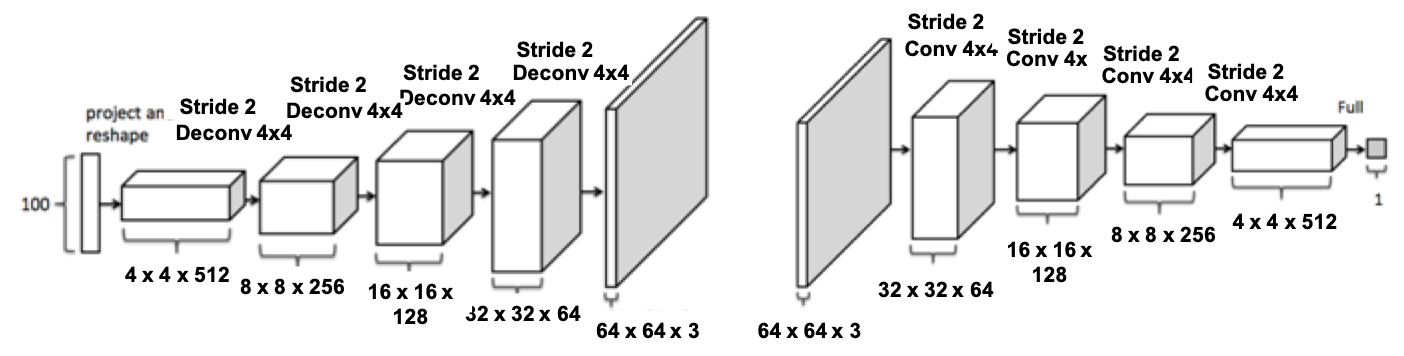

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),  # in_channels, out_channels, kernel_size, stride, padding
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 (R,G,B) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False), # in_channels, out_channels, kernel_size, stride, padding
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# weigth initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)        

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### **Loss function & optimizers**
Binary cross entropy loss: 

<a href="https://www.codecogs.com/eqnedit.php?latex=L=-\frac{1}{m}\sum&space;\left&space;[&space;y_{i}log(\hat{y}_{i})&space;&plus;&space;(1-{y_{i}})log(1-\hat{y}_{i})\right&space;]" target="_blank"><img src="https://latex.codecogs.com/gif.latex?L=-\frac{1}{m}\sum&space;\left&space;[&space;y_{i}log(\hat{y}_{i})&space;&plus;&space;(1-{y_{i}})log(1-\hat{y}_{i})\right&space;]" title="L=-\frac{1}{m}\sum \left [ y_{i}log(\hat{y}_{i}) + (1-{y_{i}})log(1-\hat{y}_{i})\right ]" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=y_{i}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?y_{i}" title="y_{i}" /></a> = 0 (generated) or 1 (real)

In [ ]:
lossFun = nn.BCELoss()

lr = 0.0002;
beta1 = 0.9;
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
# fixed_noise = torch.randn(64, 100, 1, 1, device=device)

### **Training**
In each batch, the training processes are as follows


1.   Using real images
  *   Forward pass real batch through Discriminator
  *   Calculate gradients for Discriminator in backward pass: errD_real.backward()

2.   Using fake images
  *   Generate fake image batch with Generator: fake
  *   Forward pass fake batch (fake.detach()) through Discriminator
  *   Calculate gradients for Discriminator in backward pass: errD_fake.backward()
  *   Add the gradients from the all-real and all-fake batches: 
      *   errD = errD_real + errD_fake 
  *   Update Discriminator
      *  optimizerD only updates netD and the gradients on netG are not used before netG.zero_grad() is called, so detaching is not necessary, it just saves time, because you're not computing gradients for the generator.

3.   Update Generator
  *   Assign real_label to fake image
  *   Forward pass fake batch (fake) through the updated Discriminator
  *   Bsed on this output, calculate gradients for Generator in backward pass: errG.backward()
  *   Update Generator  


In [ ]:
# load pre-trained model to resume the training
D_loss = [];
G_loss = [];
epoch_base = 3
model_path = '/content/drive/MyDrive/MachineLearning/CNN_implementation/DCGAN/DCGAN_face.pt';

if os.path.exists(model_path):
    checkpoint = torch.load(model_path);

    netD.load_state_dict(checkpoint['netD_state_dict'])
    netG.load_state_dict(checkpoint['netG_state_dict'])

    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

    D_loss = checkpoint['D_loss'];
    G_loss = checkpoint['G_loss'];

    epoch_base = checkpoint['epoch_base']

epoch: 3, [0/6331] loss D: 0.1399194598197937, loss G: 4.6521315574646


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


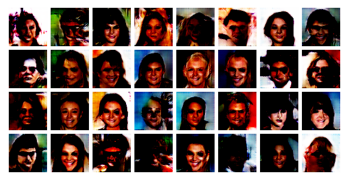

epoch: 3, [200/6331] loss D: 0.44162437319755554, loss G: 6.051131248474121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


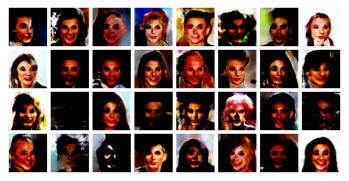

epoch: 3, [400/6331] loss D: 1.882704734802246, loss G: 4.918420791625977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


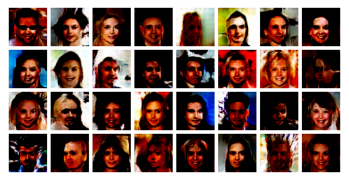

epoch: 3, [600/6331] loss D: 0.197053924202919, loss G: 6.270751953125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


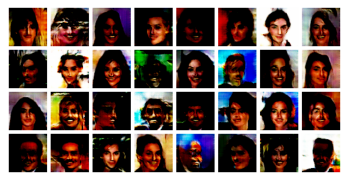

epoch: 3, [800/6331] loss D: 0.21568869054317474, loss G: 3.1298587322235107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


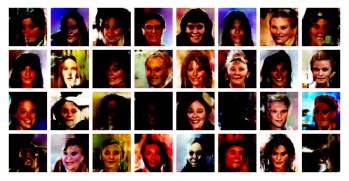

In [ ]:
num_epochs = 1
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(celeb_loader, 0):
        ### 1. Using real images
        batch_now = data.to(device)
        netD.zero_grad() # safer than optimizerD.zero_grad()?
        real_label = torch.ones((batch_size,),device=device) # default type is float
        ### Forward pass real batch through Discriminator
        output = netD(batch_now).view(-1)
        ### Calculate loss 
        errD_real = lossFun(output, real_label)
        ### Calculate gradients for Disriminator in backward pass
        errD_real.backward()        

        ### 2. Generate fake images 
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        fake_label = torch.zeros((batch_size,),device=device) # default type is float
        ### Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)
        ### Calculate loss
        errD_fake = lossFun(output, fake_label)
        ### Calculate the gradients for Discriminator in backword pass
        errD_fake.backward()        

        ### Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        ### Update Discriminator
        optimizerD.step()


        ### 3. Working on Generator
        netG.zero_grad()
        ### Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)        
        ### Calculate G's loss based on this output: G's goal is to make all images realistic
        errG = lossFun(output, real_label)        
        ### Calculate gradients for G
        errG.backward()        
        ### Update Generator
        optimizerG.step()       

        D_loss.append(errD.item())
        G_loss.append(errG.item())

        ### Print training stats
        if i % 200 == 0:
            print('epoch: '+str(epoch + epoch_base)+', ['+str(i)+'/'+str(len(celeb_loader))+'] '+
                  'loss D: '+str(errD.item())+', loss G: '+str(errG.item()))
            
            ### save checkpoint            
            checkpoint = {'netD_state_dict': netD.state_dict(),
                          'netG_state_dict': netG.state_dict(),
                          'optimizerD_state_dict': optimizerD.state_dict(),
                          'optimizerG_state_dict': optimizerG.state_dict(),
                          'D_loss': D_loss,
                          'G_loss': G_loss,
                          'epoch_base': epoch_base}
            torch.save(checkpoint, model_path)    

            ### Draw generated images
            imgMtx = np.ndarray((70*4,70*8,3));
            for i in range(32):
                row = int(np.floor(i/8))
                col = int(i%8)
                
                imgNow = np.ones((70,70,3))
                aaa = np.array(fake.detach().cpu()[i,:,:,:])
                aaa = np.transpose(aaa,(1,2,0));

                imgNow[3:67,3:67,:] = aaa;
                imgMtx[row*70:((row+1)*70),col*70:((col+1)*70),0:3] = imgNow
            plt.imshow(imgMtx)
            plt.axis('off')
            plt.pause(1)    


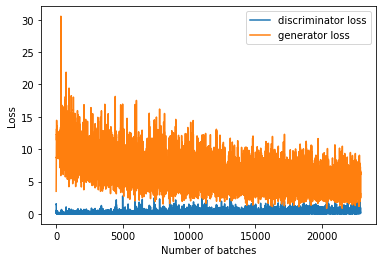

In [ ]:
disc_loss, = plt.plot(D_loss,label='discriminator loss')
gen_loss, = plt.plot(G_loss,label='generator loss')
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.legend(handles=[disc_loss, gen_loss])